# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [1]:
# Load Libraries
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 7)


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load pickled data

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len (X_train)

# TODO: number of testing examples
n_test = len (X_test)

# TODO: what's the shape of an image?
image_shape = X_train.shape[1:]

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

### Visualization that demonstrates the available types of traffic signs.

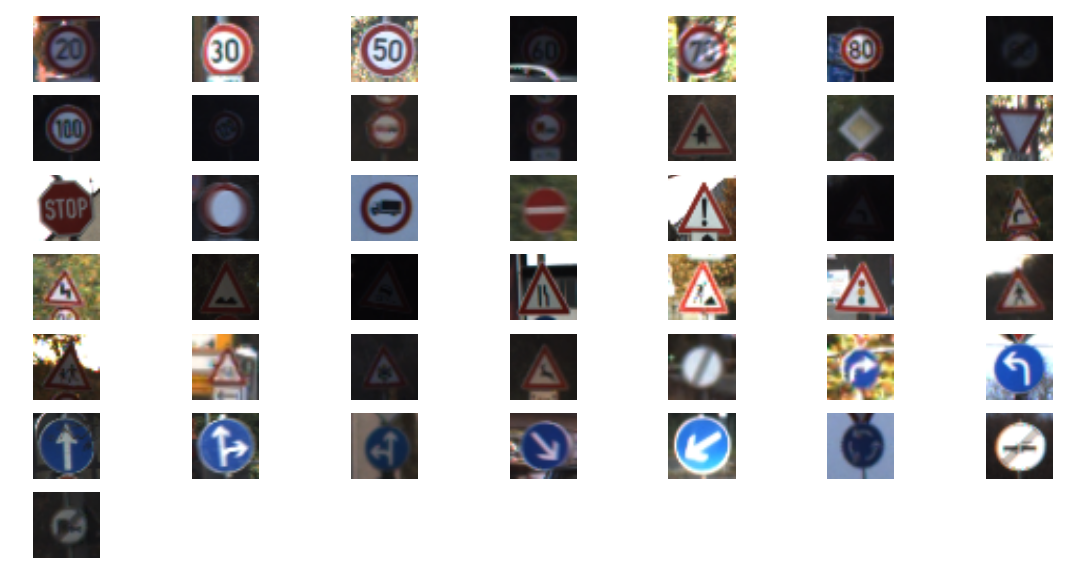

In [4]:
label_type=[]
for i  in  range(0,n_classes):
    plt.subplot(7,7,i+1)
    label_type.append(X_test[np.where( y_test == i )[0][0],:,:,:].squeeze())
    img = plt.imshow(X_test[np.where( y_test == i )[0][0],:,:,:].squeeze())
    plt.axis('off')

### Visualization that demonstrates the occurrence distribution for different types of traffic signs.

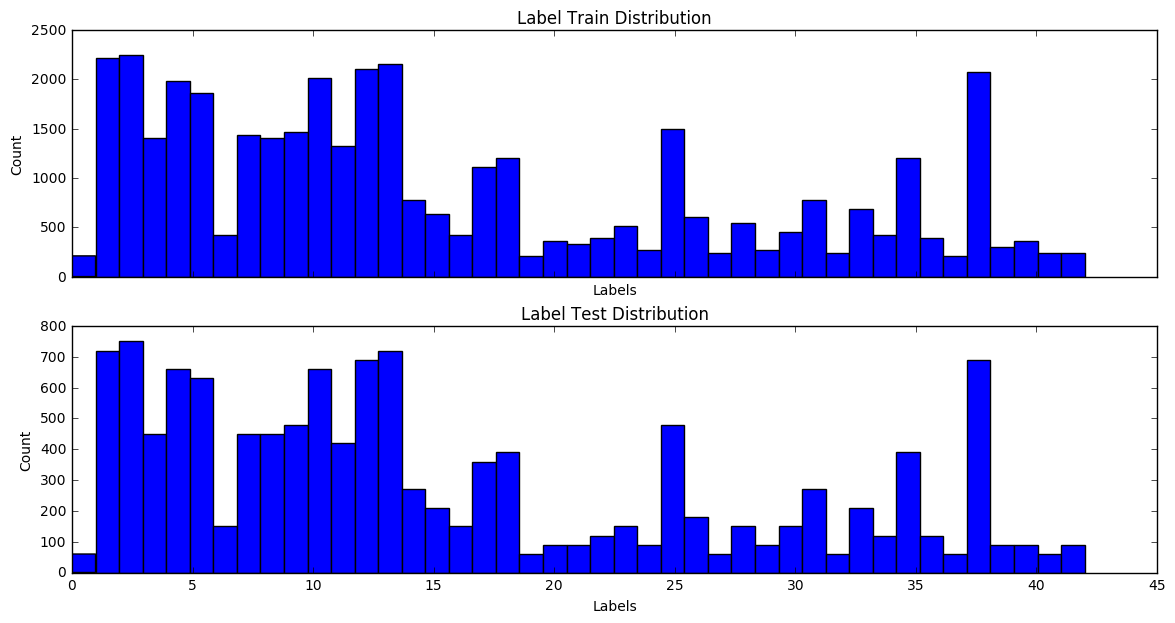

In [7]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2, sharex=True)
axarr[0].hist(y_train,bins=n_classes)
axarr[0].set_title('Label Train Distribution')
axarr[0].set_xlabel('Labels')
axarr[0].set_ylabel('Count')
axarr[1].hist(y_test,bins=n_classes)
axarr[1].set_title('Label Test Distribution')
axarr[1].set_xlabel('Labels')
axarr[1].set_ylabel('Count')


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

### Normalize the figures

In [8]:
# Implement Min-Max scaling for image data
def normalize_scale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return (a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) ) )

In [9]:

X_test_t= numpy.zeros((X_test.shape[0],X_test.shape[1]*X_test.shape[2],X_test.shape[3]), dtype=float)
X_train_t= numpy.zeros((X_train.shape[0],X_train.shape[1]*X_train.shape[2],X_train.shape[3]), dtype=float)


for i in range (X_test.shape[3]):
    X_test_t[:,:,i]=normalize_scale(X_test[:,:,:,i].reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
    X_train_t[:,:,i]=normalize_scale(X_train[:,:,:,i].reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
    
    

X_test_t=X_test_t.reshape(X_test_t.shape[0], X_test_t.shape[1]*X_test_t.shape[2])
X_train_t=X_train_t.reshape(X_train_t.shape[0], X_train_t.shape[1]*X_train_t.shape[2])


### Transform labels using One-Hot Encoding

In [10]:
from sklearn.preprocessing import LabelBinarizer

# Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
is_labels_encod = True

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


### Question 1 

_Describe the techniques used to preprocess the data._



**Answer:** For this project we obtained colorful images with different illumination condition. Each image has a label that describes the type of traffic sign. 

 * In order to reduce the **total variance** in the dataset and simplify the training I normalized each figure with respect to the values0-255 -> 0.1 -0.9. The normalization was performed on each color separately. That was done in order to enhance **variation between** different colors. 
 * For the target variable I simply transform the type of the different traffic signs using One-Hot Encoding. 

In [2]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Splitting and randomize datasets for training and validation sets

In [11]:
from sklearn.cross_validation import train_test_split

# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    X_train_t,
    y_train,
    test_size=0.3,
    random_state=0)

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:** The provided dataset was separated into training and testing. Therefore, I used the function "train_test_split", to shuffle and split the training set into training (70%) and validation (30%). The idea was that the validation and the testing will have similar size. 

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** For this problem I am using the ** multi-layer perceptron feedforward model**. The neural network include **2 layers**, the size of the hidden layer, or the **width of a layer is 512**. Each layer include also **RELU** activation layer in order to include non linear components in the network. The input size is 3072, the output size is 43.

The **cost** function is calculated using the **[softmax_cross_entropy_with_logits](http://stackoverflow.com/questions/34240703/difference-between-tensorflow-tf-nn-softmax-and-tf-nn-softmax-cross-entropy-with)**. 

**Accuraccy** is also being calculated. 

I also consider to use convolution network here because it seems more appropriate for this type of problem, the reason is that the sign might change the relative location of the image. However, I still struggling with how to implement that and I would like to get a feedback on this report before continue further. 

In [5]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Deep Neural Network in TensorFlow 2 hidden_layer

In [12]:
#### # Parameters

n_input = train_features.shape[1]
n_classes = train_labels.shape[1]

# Parameters
learning_rate =  0.001
training_epochs = 20
batch_size = 1000
display_step = 1
#del logits

# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

 
n_hidden_layer1 = 256 #1st layer number of features
n_hidden_layer2 = 256 # 2nd layer number of features



# Store layers weight & bias
weights = {
    'hidden_layer1': tf.Variable(tf.random_normal([n_input, n_hidden_layer1], mean=0, stddev=0.01)),
    'hidden_layer2': tf.Variable(tf.random_normal([n_hidden_layer1, n_hidden_layer2], mean=0, stddev=0.01)),
    'out': tf.Variable(tf.random_normal([n_hidden_layer2, n_classes]))
}
biases = {
    'hidden_layer1': tf.Variable(tf.random_normal([n_hidden_layer1], mean=0, stddev=0.01)),
    'hidden_layer2': tf.Variable(tf.random_normal([n_hidden_layer2], mean=0, stddev=0.01)),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

 
# Hidden layer 1 with RELU activation
layer_1 = tf.add(tf.matmul(x, weights['hidden_layer1']), biases['hidden_layer1'])
layer_1 = tf.nn.relu(layer_1)

# Hidden layer 2 with RELU activation

layer_2 = tf.add(tf.matmul(layer_1, weights['hidden_layer2']), biases['hidden_layer2'])
layer_2 = tf.nn.relu(layer_2)

# Output layer with linear activation
logits = tf.matmul(layer_2, weights['out']) + biases['out']

prediction = tf.nn.softmax(logits)
predict = tf.argmax(logits, 1) 
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

# Define loss and optimizer
#cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))

#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
# Initializing the variables
sess = tf.Session()

sess.run(tf.initialize_all_variables())
train_acc_batch =[]
val_acc_batch =[]
train_cost_batch =[]
batches = []
# Launch the graph

#sess.run(init)
    # Training cycle
for epoch in range(training_epochs):
          
        ########################################
    for offset in range(0, train_labels.shape[0], batch_size):
            # Get a batch of training features and labels
        end = offset + batch_size
        batch_features = train_features[offset:end]
        batch_labels = train_labels[offset:end]

            #################################3
            # Run optimizer and get loss
        sess.run([optimizer], feed_dict={x: batch_features, y: batch_labels})
    if epoch % display_step == 0:
        batches.append(offset)
        c = sess.run(cost,feed_dict={x: batch_features, y: batch_labels})
        print('Epoch {:>2}/{}'.format(epoch+1, training_epochs), "cost=", "{:.5f}".format(c))
        a = sess.run(  accuracy , feed_dict={x: batch_features, y: batch_labels})
       # a = sess.run(accuracy(feed_dict={x: batch_features, y: batch_labels})    )        
        print("Accuracy train:", "{:.5f}".format(a))
        train_cost_batch.append([c])
        train_acc_batch.append([a])

        a = sess.run(  accuracy , feed_dict= {x: valid_features, y:  valid_labels})         
            
        print("Accuracy Val:", "{:.5f}".format(a))
            
            
        val_acc_batch.append([a])

    # Test model
a = sess.run(  accuracy , feed_dict={x: X_test_t, y:  y_test}) 
print("Accuracy:", a)


Epoch  1/20 cost= 3.36456
Accuracy train: 0.11883
Accuracy Val: 0.11825
Epoch  2/20 cost= 2.78085
Accuracy train: 0.30269
Accuracy Val: 0.28377
Epoch  3/20 cost= 2.30356
Accuracy train: 0.41928
Accuracy Val: 0.38562
Epoch  4/20 cost= 1.95686
Accuracy train: 0.53139
Accuracy Val: 0.48381
Epoch  5/20 cost= 1.69817
Accuracy train: 0.56726
Accuracy Val: 0.54977
Epoch  6/20 cost= 1.50212
Accuracy train: 0.60762
Accuracy Val: 0.58046
Epoch  7/20 cost= 1.33978
Accuracy train: 0.62108
Accuracy Val: 0.61319
Epoch  8/20 cost= 1.18884
Accuracy train: 0.67489
Accuracy Val: 0.66378
Epoch  9/20 cost= 1.04274
Accuracy train: 0.71076
Accuracy Val: 0.71895
Epoch 10/20 cost= 0.96220
Accuracy train: 0.74439
Accuracy Val: 0.74479
Epoch 11/20 cost= 0.89927
Accuracy train: 0.76457
Accuracy Val: 0.75933
Epoch 12/20 cost= 0.81764
Accuracy train: 0.78027
Accuracy Val: 0.77812
Epoch 13/20 cost= 0.74610
Accuracy train: 0.80493
Accuracy Val: 0.79334
Epoch 14/20 cost= 0.70175
Accuracy train: 0.80942
Accuracy Val: 

### Visualization for the cost and accuracy (y-axis) with respect to the "training epochs** ( x-axis).

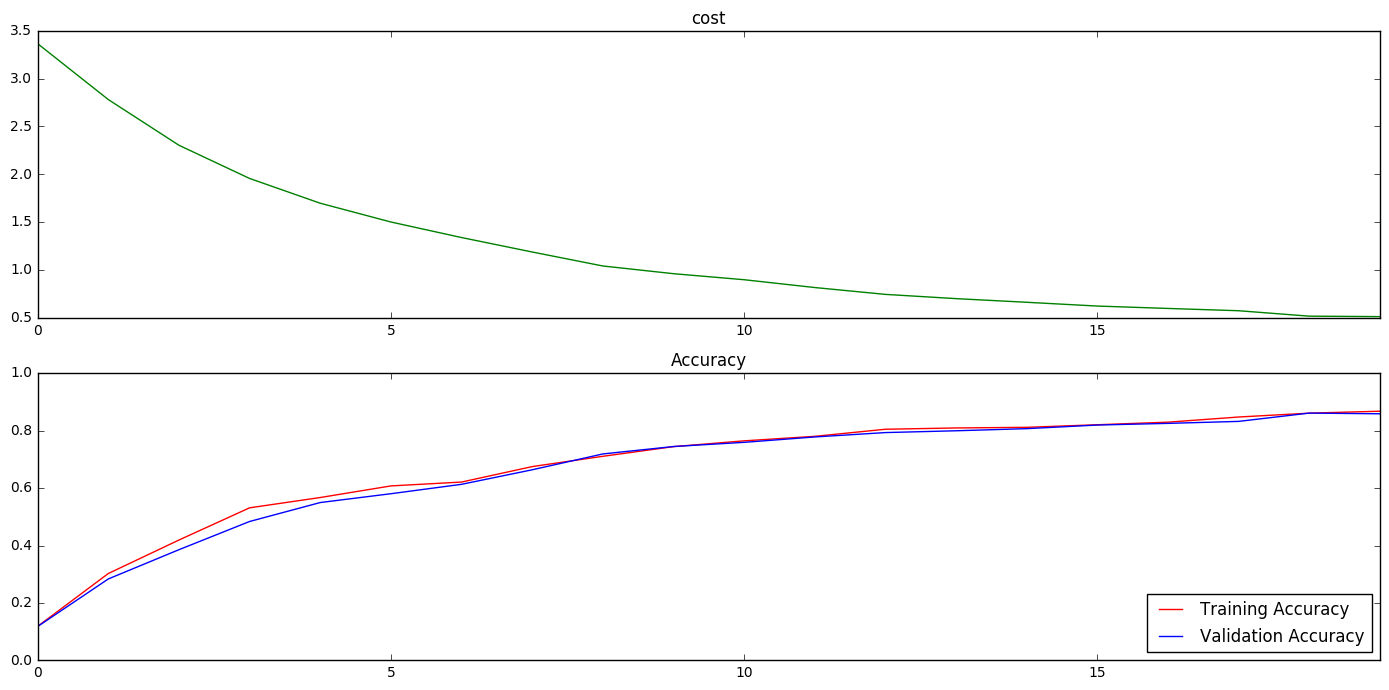

In [13]:
batches=    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 ,14 ,15, 16, 17, 18 ,19 ]
loss_plot = plt.subplot(211)
loss_plot.set_title('cost')
loss_plot.plot(batches, train_cost_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, val_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** The model was trained with learning rate =0.001, training_epochs = 20, batch_size = 1000. 

The **optimization** is done using the ** [AdamOptimizer](http://stats.stackexchange.com/questions/184448/difference-between-gradientdescentoptimizer-and-adamoptimizer-tensorflow)**. 

#### AdamOptimizer
uses moving averages of the parameters (momentum). This enables Adam to use a larger effective step size, and the algorithm will converge to this step size without fine tuning.

The main down side of the algorithm is that Adam requires more computation to be performed for each parameter in each training step (to maintain the moving averages and variance, and calculate the scaled gradient); and more state to be retained for each parameter (approximately tripling the size of the model to store the average and variance for each parameter).

**Important** the training continue till the "accuracy" fail to improving.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:** The main idea was to follow the steps of the problem that was introduced in the class (MINS problem), the reason is that the problems are quite similar, namely : "figures that need to be categorized". In addition, it is worth to mention here that the problems are not identical. The images include colors, the images are larger and the labels are not equally distributed.

This lead me to choose a larger network, but at the same time, I did not want the network to be too large ( save computation time and avoid overfitting). I try a different number of layers and different width of a layer. I was making sure that the network will not overfit the data (examine the performance accuracy as training epoch increase), but also try to minimize the computation time.  

After choosing the "feedforward model" I went ahead and experiment few parameter of the model to identify the optimal model. When I used only one layer the performance was quite low, so I increase the width of the layer, the results was better but not quite and the training was longer. So I include another layer and reduce the width of the layer. The outcome from this network was higher. However when I increase the number of layers further I obtained null in the cost so I decided to use a lower number of layers that still provides a reasnable result. 

After I obtained a the networked that was satisfing I choose large number of epochs. The result of this analysis provide me the accuraccy chart. From this chart I chossen number of epoch that provide reasnable but high performance but still low so it will not take to long to train the model. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:** The signs are span over most of the figure, so this is good for the model. However, 
 * the **"working on road"** sign have different colors, it is yellow in the test but in the training it was white. 
 * The **"stop"** sign is tilted, that might be problematic for the model. 
 * The **"truck"** sign is not completly clear and some text appear on the bottom, that  might also make it difficult for the model.
 * The **"turn left"** figure have some objects on the backgraound.  
 

In [15]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
from scipy import misc
import matplotlib.pyplot as plt
import os
import pandas as pd
%matplotlib inline

In [16]:
imgs = []
for filename in os.listdir('signs'):
    img = plt.imread('signs/' + filename)
    imgs.append(img)
    print(filename, img.shape)

sign_4.jpg (32, 32, 3)
sign_5.jpg (32, 32, 3)
sign_1.jpg (32, 32, 3)
sign_3.jpg (32, 32, 3)
sign_2.jpg (32, 32, 3)


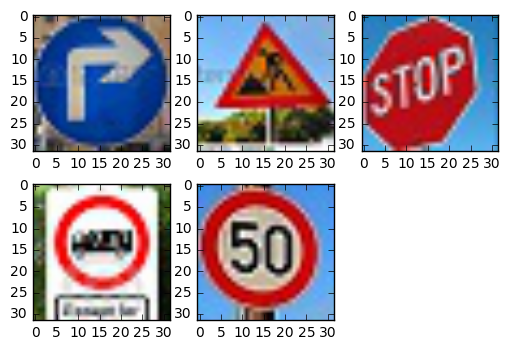

In [17]:
fig = plt.figure()
fig.add_subplot(2,3,1)
plt.imshow(imgs[0])
fig.add_subplot(2,3,2)
plt.imshow(imgs[1])
fig.add_subplot(2,3,3)
plt.imshow(imgs[2])
fig.add_subplot(2,3,4)
plt.imshow(imgs[3])
fig.add_subplot(2,3,5)
plt.imshow(imgs[4])

In [18]:
A=np.array(imgs)

A_t= numpy.zeros((A.shape[0],A.shape[1]*A.shape[2],A.shape[3]), dtype=float)


for i in range (A.shape[3]):
    A_t[:,:,i]=normalize_scale(A[:,:,:,i].reshape(A.shape[0], A.shape[1]*A.shape[2]))
    
A_t=A_t.reshape(A_t.shape[0], A_t.shape[1]*A_t.shape[2])


In [28]:
preds = sess.run(predict, feed_dict={x: A_t})
print(preds)



[33  5 14  4  8]


### The sampled signs (upper row) and the predicted sign (lower row). 

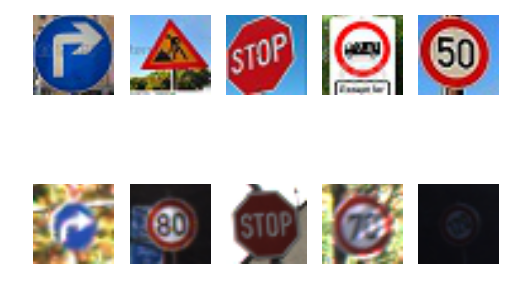

In [25]:
fig = plt.figure()
for i in [1,2,3,4,5]:
    fig.add_subplot(2,5,i)
    plt.imshow(A[i-1,:,:,:]) 
    plt.axis('off')
    fig.add_subplot(2,5,i+5)
    plt.imshow(label_type[preds[i-1]])
    plt.axis('off')

#### Figure : 
On the top raw the traffic signs obtaine from the internet. On the bottom row example of the predicted type of traffic sign from the training set. So for example, we can see that the stop sign was predicted correctly, but the "work on the road" sign was predicted as "maximum 80" . 

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:** Unfortunately the answer is no. For the test-set I obtained 70% where here the success is only ~40%.  I did try to choose figures that might be a challenge. For example, the working on road  sign has different colors. But my greatest surprise was that the model did not recognize the numbers correctly.  

In [37]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
top_k_preds = sess.run(tf.nn.top_k(prediction , k=5), feed_dict={x: A_t})
print(top_k_preds.values)
print(top_k_preds.indices)

[[  9.05434489e-01   8.41022283e-02   4.42479132e-03   2.62350659e-03
    2.12941645e-03]
 [  6.62209153e-01   2.36208275e-01   9.81614441e-02   1.56143028e-03
    6.23478263e-04]
 [  9.98374343e-01   8.03765026e-04   4.00916877e-04   3.50905932e-04
    1.87682544e-05]
 [  9.96091068e-01   3.75055848e-03   5.86856368e-05   4.37472590e-05
    3.58543148e-05]
 [  5.51996946e-01   4.34030801e-01   8.20369646e-03   4.45192587e-03
    8.30890087e-04]]
[[33 37 13  7 35]
 [ 5 14 25 10 21]
 [14 25 13  0  1]
 [ 4 18  1  0 14]
 [ 8  7  5  1  4]]


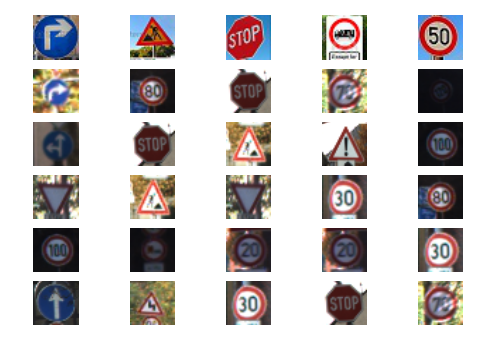

In [47]:
fig = plt.figure()

for i in [1,2,3,4,5]:
  
    fig.add_subplot(6,5,i)
    plt.imshow(A[i-1,:,:,:]) 
    plt.axis('off')
    for j in [0,1,2,3,4]:
      fig.add_subplot(6,5,i+(j+1)*5)
      plt.imshow(label_type[top_k_preds.indices[i-1][j]])
      plt.axis('off')
 
    

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


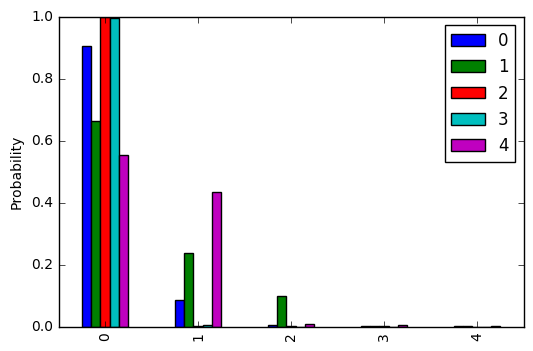

In [61]:
import pandas as pd
A=pd.DataFrame(top_k_preds.values.transpose())

A.plot(kind='bar').set_ylabel('Probability')

**Answer:** We find that for the "stop" sign, the "turn left" and the "trucks", the prediction probability is quite high, that is despite the fact that  the "truck" sign is a wrong prediction. For the other 2 predictions, we find that the probability is around 0.6 but the decrease in probability does not go fast as for the other 3. 

For the working on the road sign, we find the correct  prediction as number 3. That might also relate with the different colors of the signs.

Q: If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*
A: 
 * The prediction for the "stop" sign, the "turn left" are correct, 
 * The prediction for the "work on the road was not correct , but we find it as the third option. 
 * The prediction for the "truck" was wrong and we cannot find this prediction in the first 5 choises. 
 * The prediction for the "50" was wrong and we cannot find this prediction in the first 5 choises.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.